In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [17]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [18]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

#[independent_variables.remove(i) for i in columns_to_predict]
independent_variables.remove(columns_to_predict[0])
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
    
print(independent_variables)

['Hour_1', 'Hour_2', 'Hour_3', 'Occupant Count (people)_3', '12h Outdoor Drybulb Temperature (C)', '24h Outdoor Drybulb Temperature (C)', '12h Outdoor Relative Humidity (%)', '6h Direct Solar Radiation (W/m2)', '12h Direct Solar Radiation (W/m2)']


Prepare the data

In [19]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [20]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [21]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24, 2)
X_val = (25, 48, 9), Y_val = (25, 24, 2)
X_test = (25, 48, 9), Y_test = (25, 24, 2)


In [22]:
print(Y_train[:, :, 0])

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.47416969 0.39741721 0.28594384 ... 0.4397153  0.45619247 0.45482902]
 [0.39741721 0.28594384 0.16805223 ... 0.45619247 0.45482902 0.41836388]
 [0.28594384 0.16805223 0.12974031 ... 0.45482902 0.41836388 0.39162712]]


In [23]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 86ms/step - loss: 0.4617 - output_variable1_loss: 0.2928 - output_variable2_loss: 0.1689 - val_loss: 0.6420 - val_output_variable1_loss: 0.5496 - val_output_variable2_loss: 0.0924
Epoch 2/200
13/13 [==============================] - 0s 30ms/step - loss: 0.2842 - output_variable1_loss: 0.1588 - output_variable2_loss: 0.1254 - val_loss: 0.3711 - val_output_variable1_loss: 0.2995 - val_output_variable2_loss: 0.0716
Epoch 3/200
13/13 [==============================] - 0s 31ms/step - loss: 0.1815 - output_variable1_loss: 0.0910 - output_variable2_loss: 0.0905 - val_loss: 0.2376 - val_output_variable1_loss: 0.1872 - val_output_variable2_loss: 0.0505
Epoch 4/200
13/13 [==============================] - 0s 30ms/step - loss: 0.1216 - output_variable1_loss: 0.0586 - output_variable2_loss: 0.0631 - val_loss: 0.1843 - val_output_variable1_loss: 0.1443 - val_output_variable2_loss: 0.0400
Epoch 5/200
13/13 [==============================] - 0s 

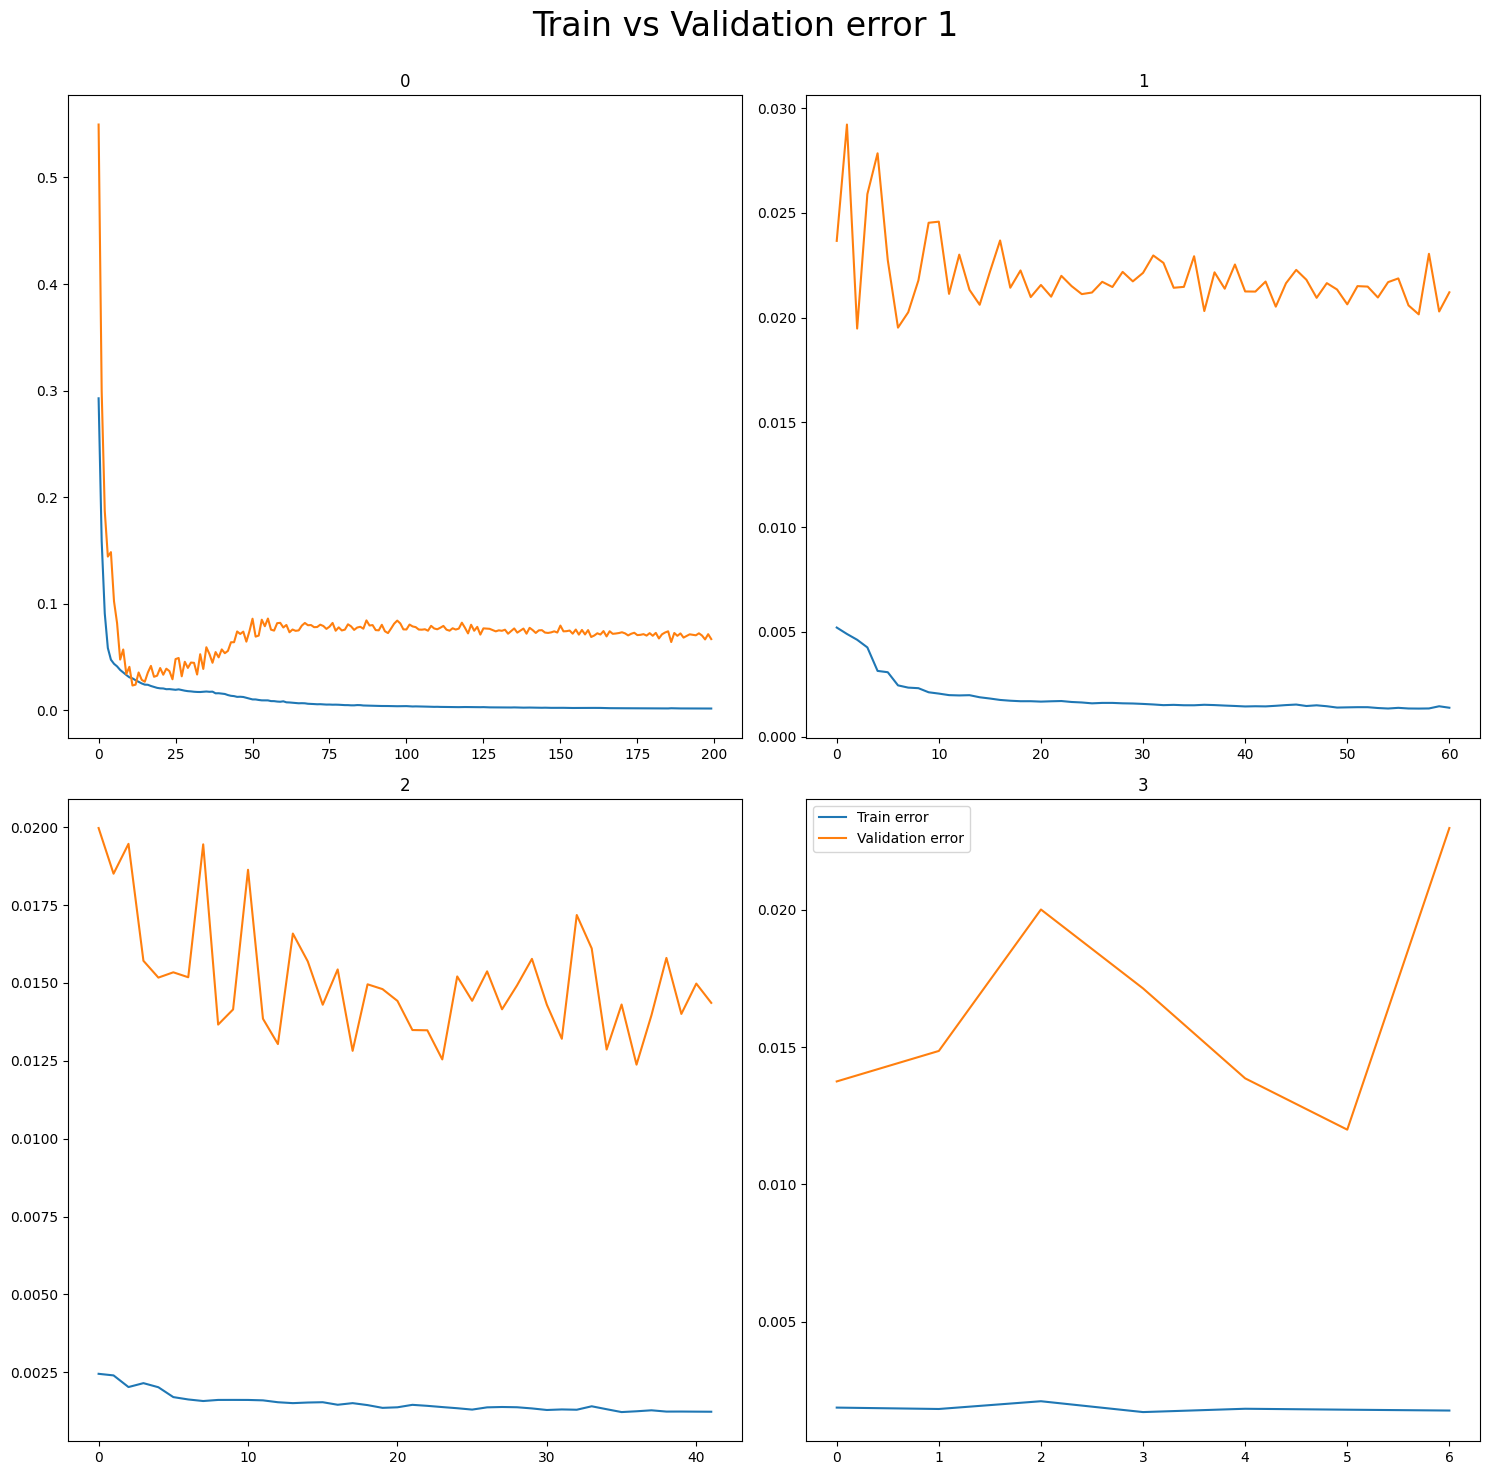

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

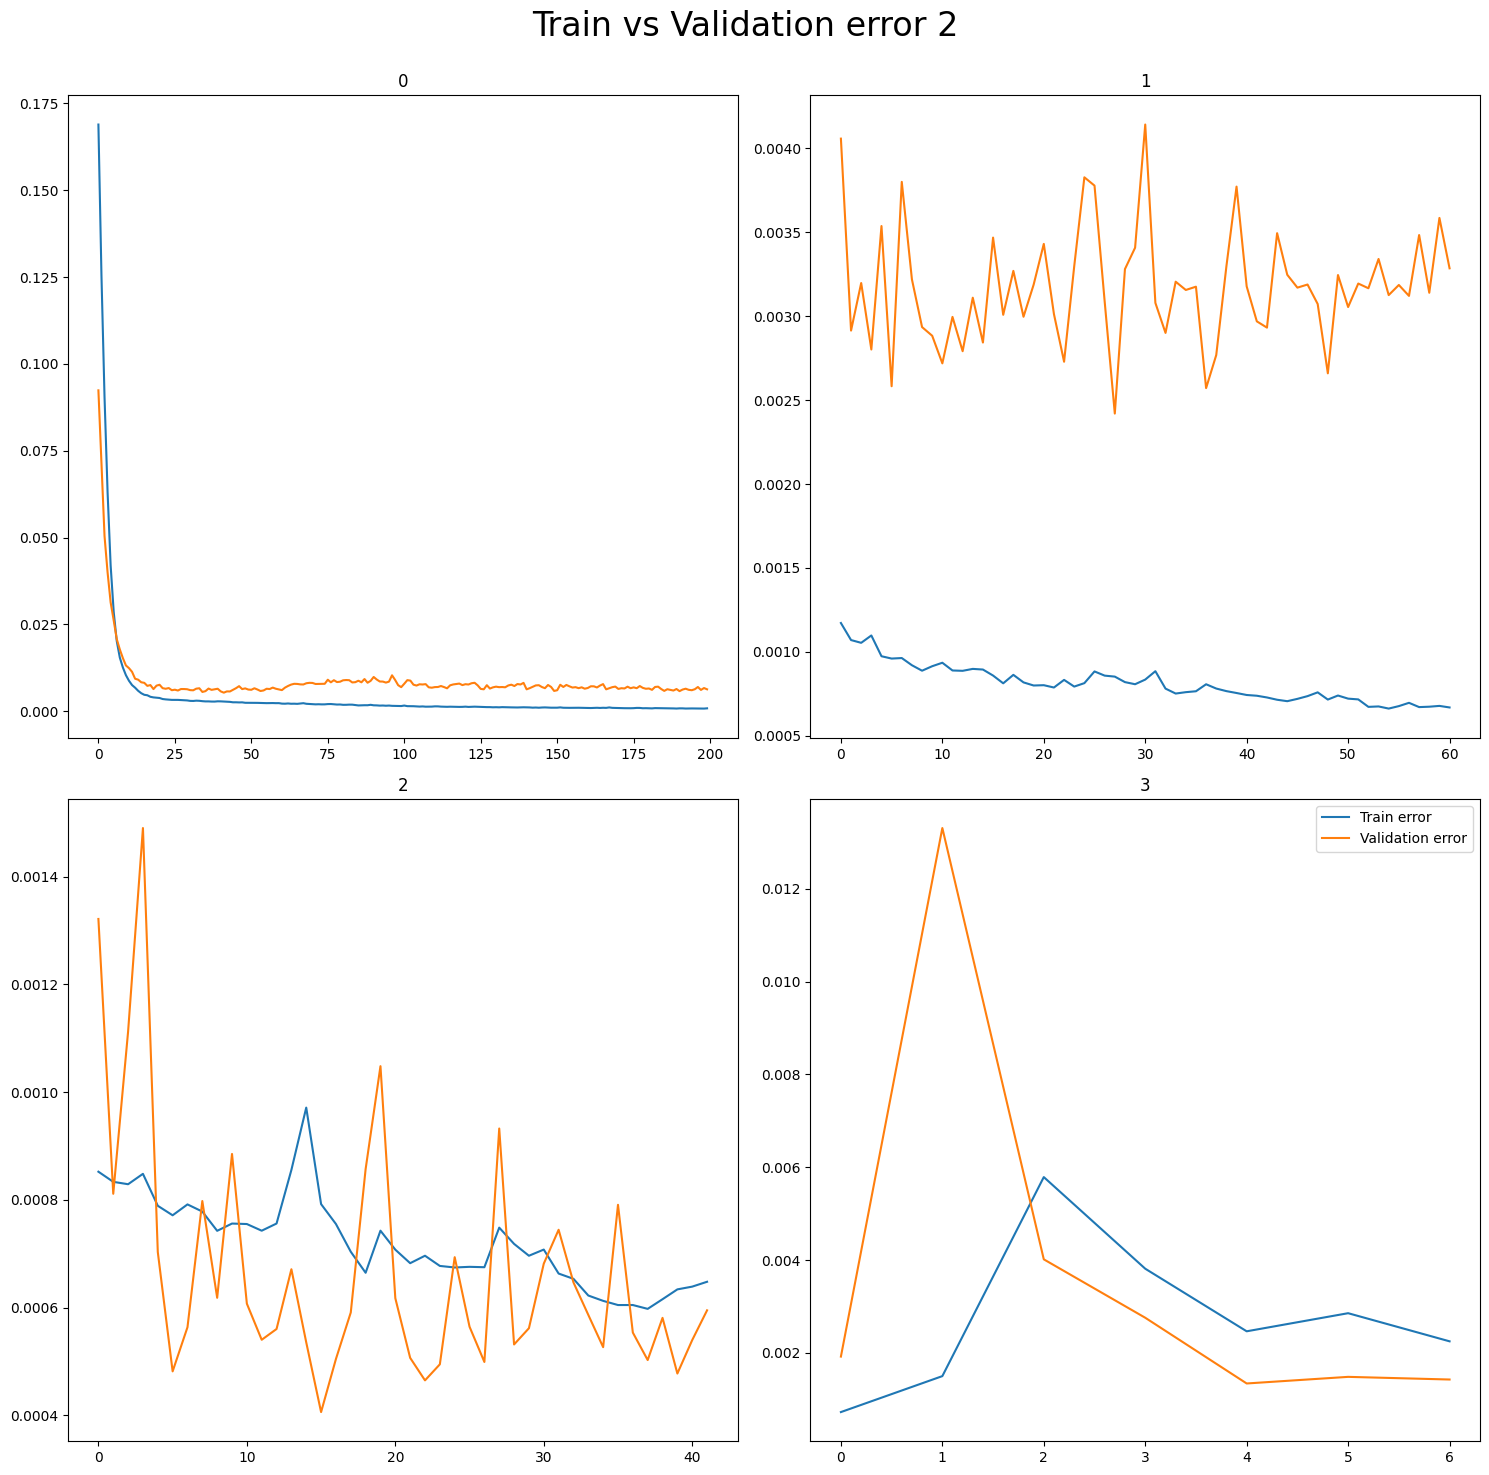

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 20ms/step


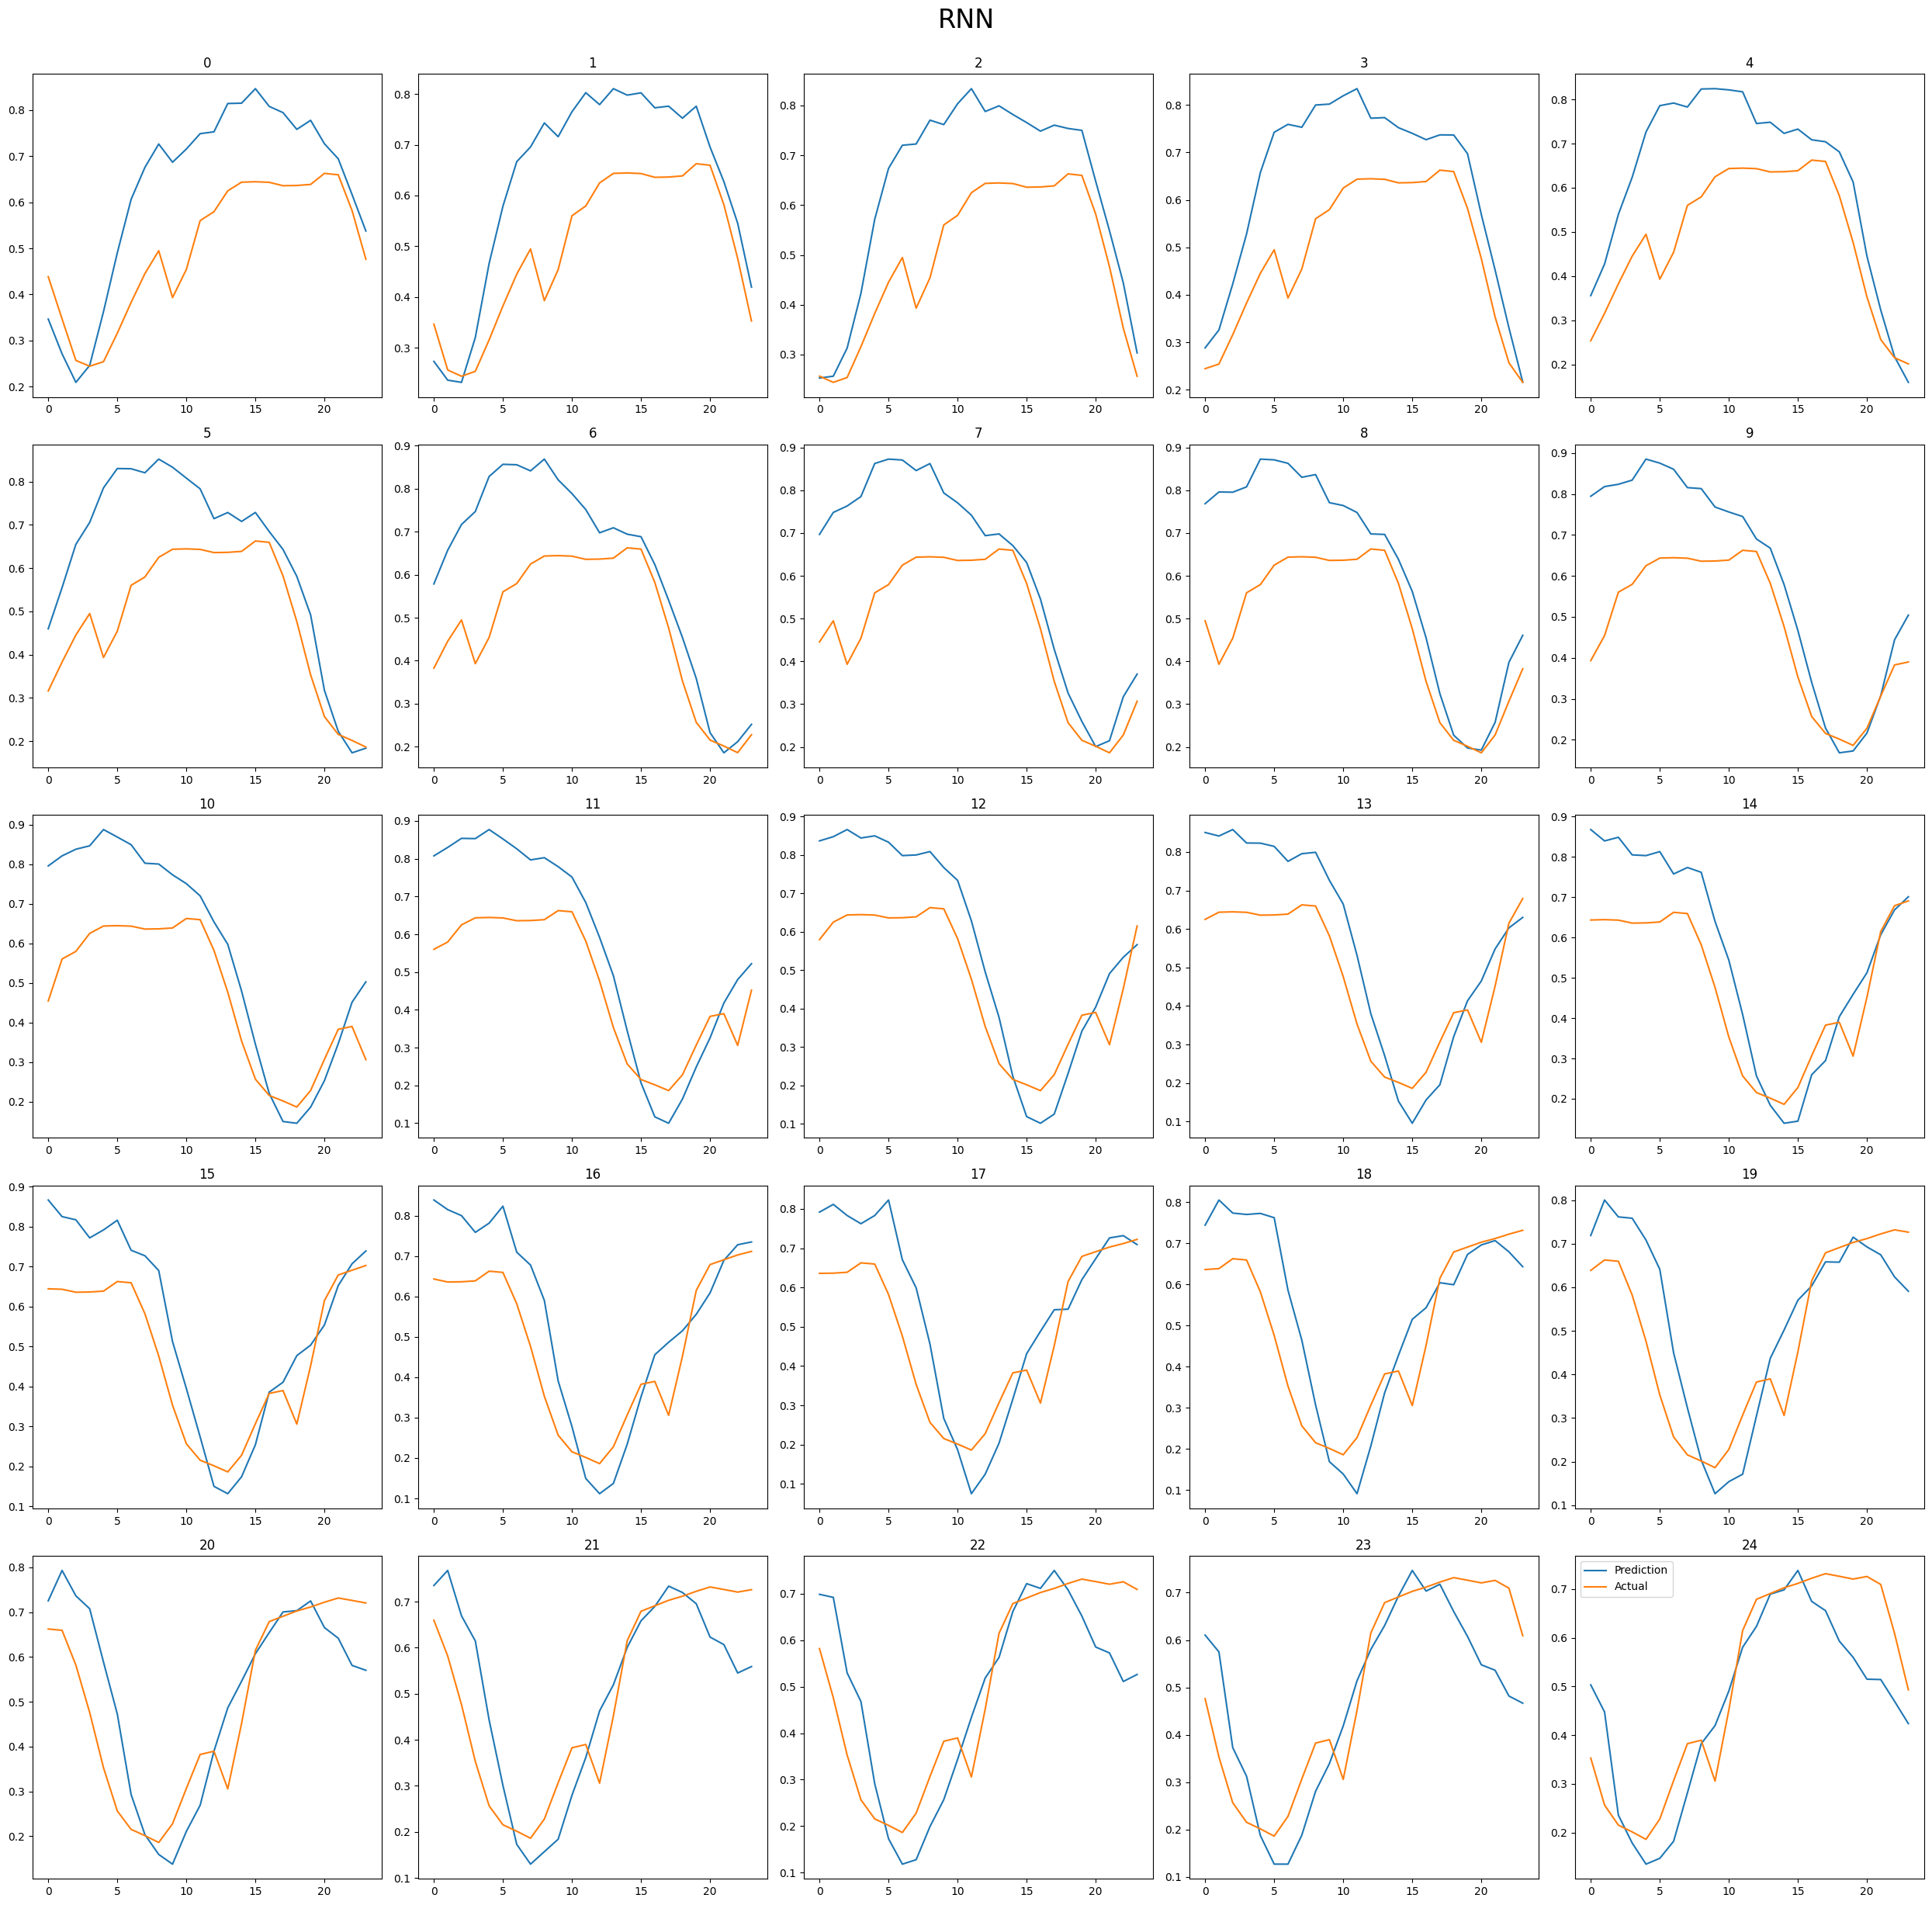

In [27]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

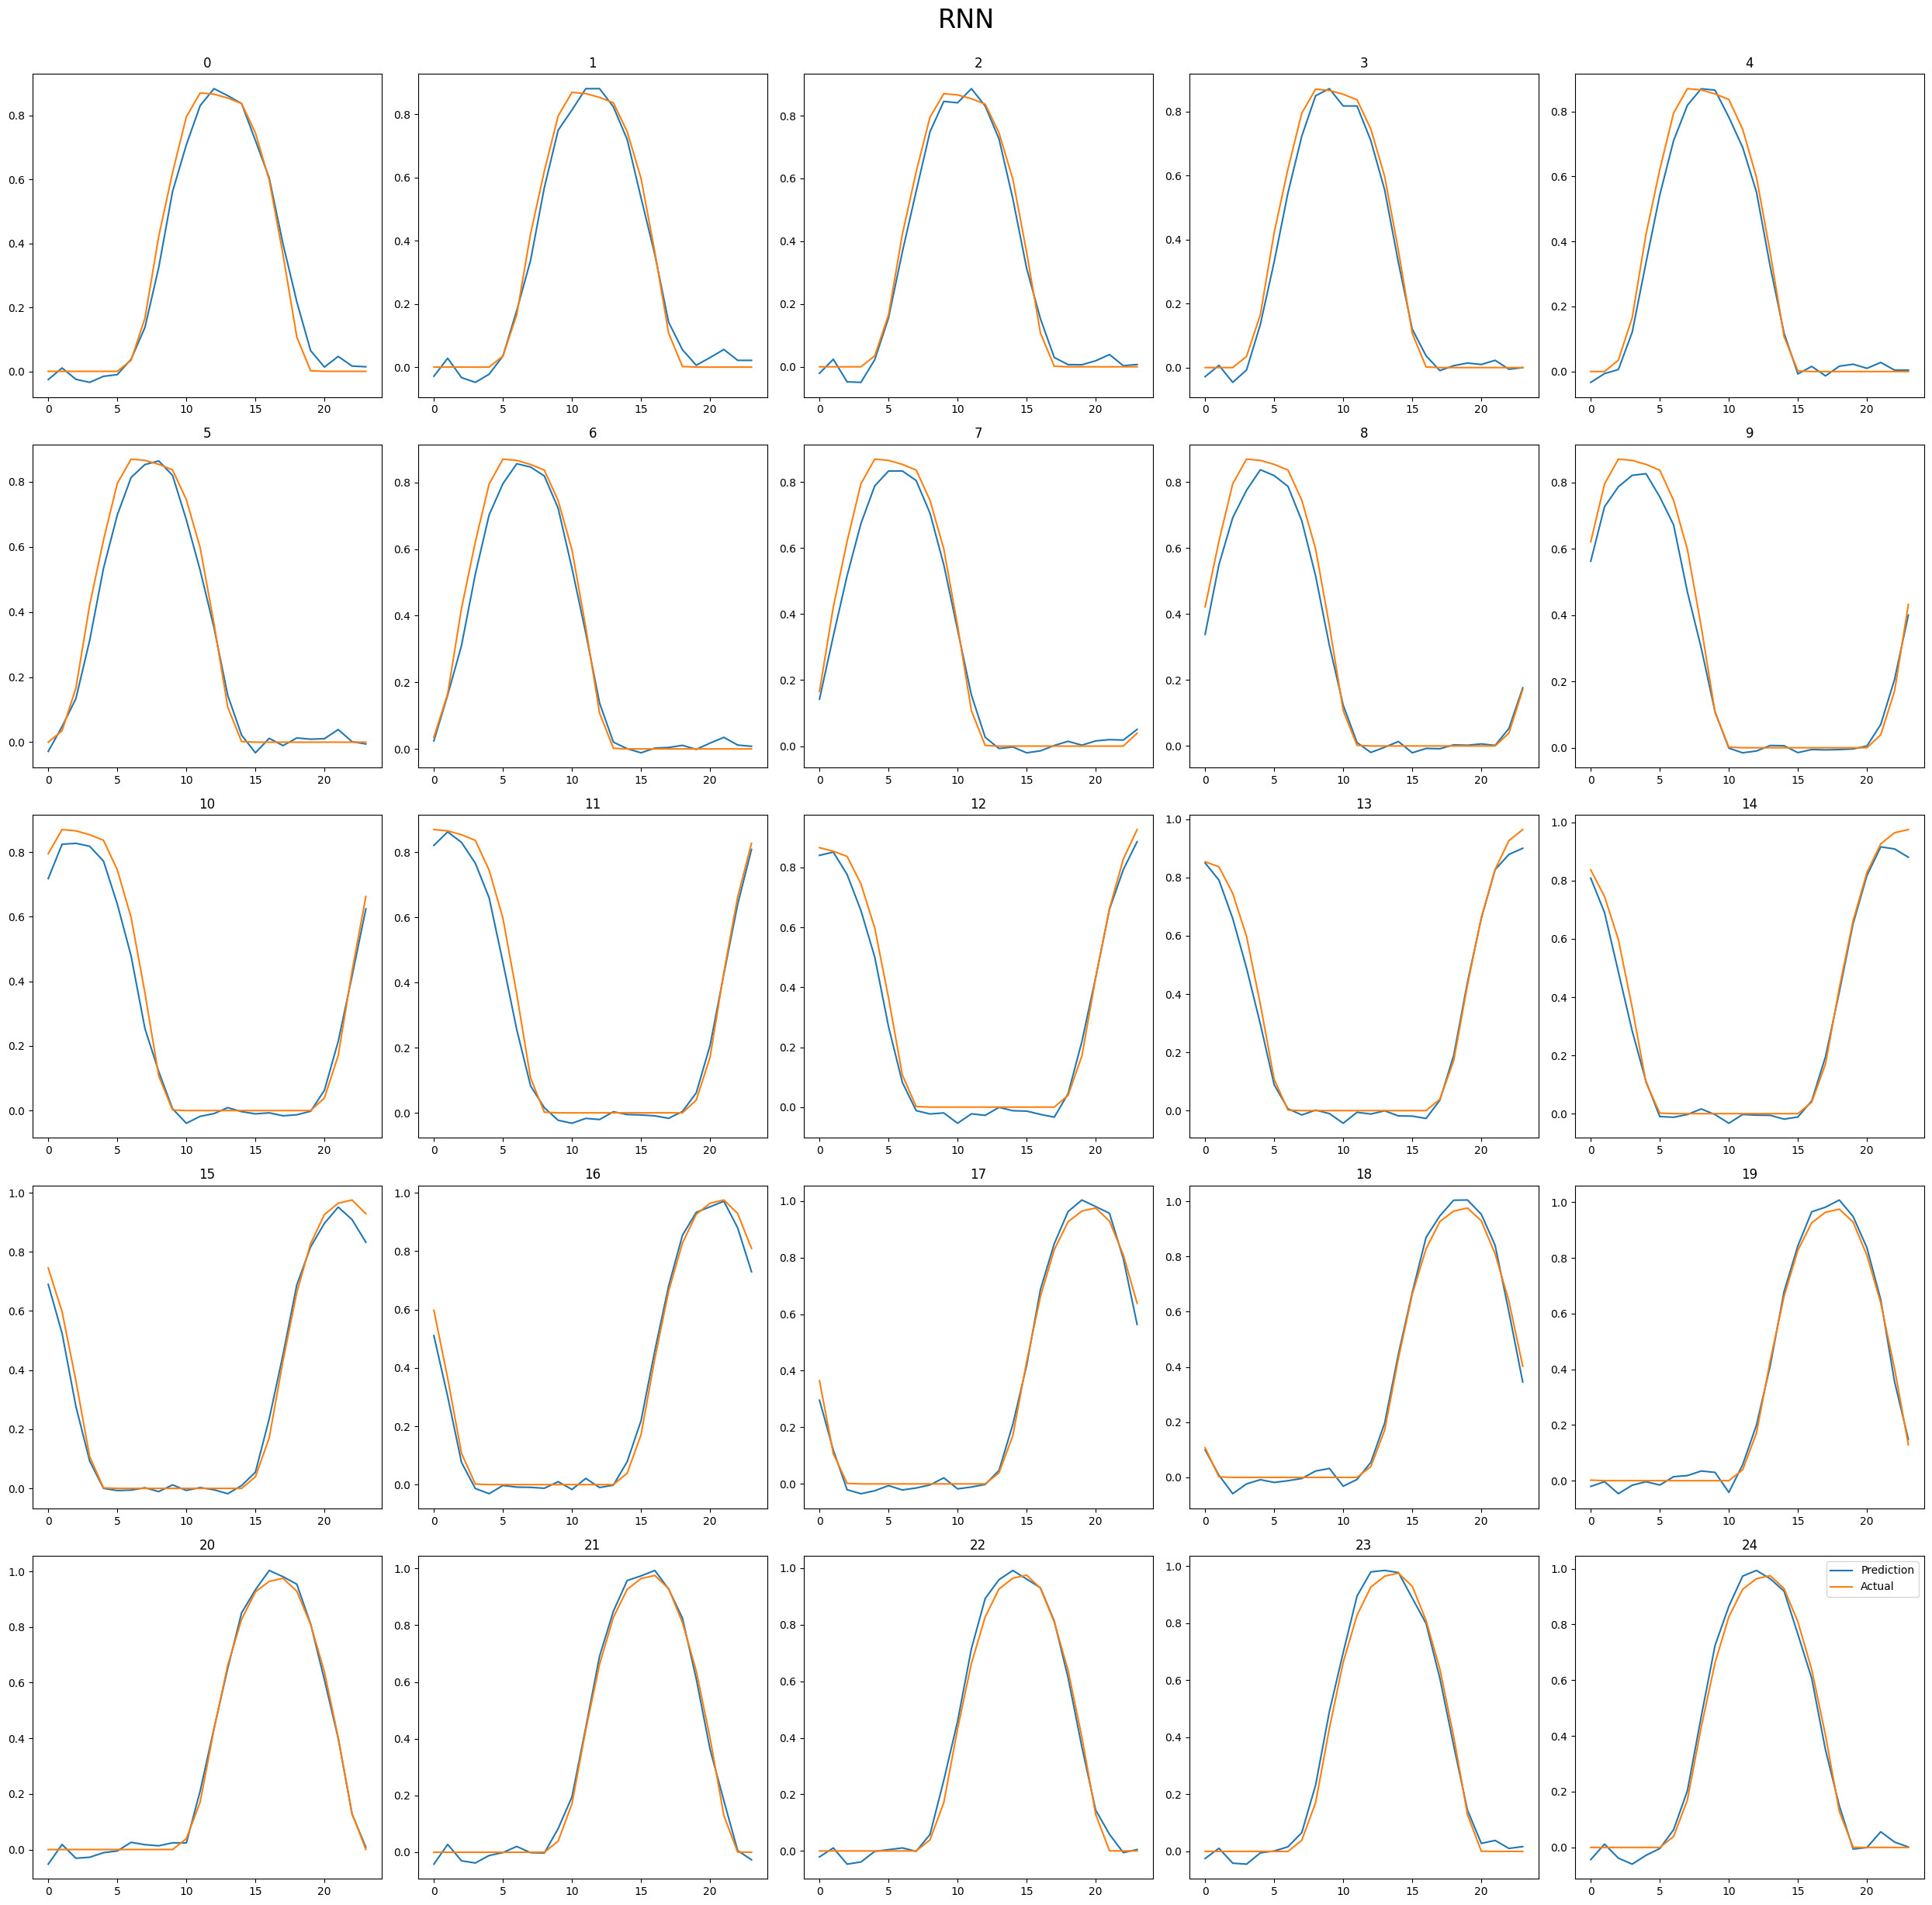

In [28]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 7) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 6s 85ms/step - loss: 0.4384 - output_variable1_loss: 0.2760 - output_variable2_loss: 0.1624 - val_loss: 0.5852 - val_output_variable1_loss: 0.5004 - val_output_variable2_loss: 0.0848
Epoch 2/200
13/13 [==============================] - 0s 29ms/step - loss: 0.2794 - output_variable1_loss: 0.1560 - output_variable2_loss: 0.1234 - val_loss: 0.3760 - val_output_variable1_loss: 0.3049 - val_output_variable2_loss: 0.0711
Epoch 3/200
13/13 [==============================] - 0s 33ms/step - loss: 0.1882 - output_variable1_loss: 0.0889 - output_variable2_loss: 0.0993 - val_loss: 0.2522 - val_output_variable1_loss: 0.1952 - val_output_variable2_loss: 0.0569
Epoch 4/200
13/13 [==============================] - 0s 30ms/step - loss: 0.1349 - output_variable1_loss: 0.0573 - output_variable2_loss: 0.0775 - val_loss: 0.1917 - val_output_variable1_loss: 0.1473 - val_output_variable2_loss: 0.0444
Epoch 5/200
13/13 [==============================] - 0s 

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 83ms/step - loss: 0.4620 - output_variable1_loss: 0.3003 - output_variable2_loss: 0.1618 - val_loss: 0.6896 - val_output_variable1_loss: 0.6013 - val_output_variable2_loss: 0.0883
Epoch 2/200
13/13 [==============================] - 0s 29ms/step - loss: 0.2897 - output_variable1_loss: 0.1670 - output_variable2_loss: 0.1228 - val_loss: 0.3333 - val_output_variable1_loss: 0.2651 - val_output_variable2_loss: 0.0682
Epoch 3/200
13/13 [==============================] - 0s 30ms/step - loss: 0.1806 - output_variable1_loss: 0.0898 - output_variable2_loss: 0.0908 - val_loss: 0.2684 - val_output_variable1_loss: 0.2178 - val_output_variable2_loss: 0.0506
Epoch 4/200
13/13 [==============================] - 0s 30ms/step - loss: 0.1206 - output_variable1_loss: 0.0596 - output_variable2_loss: 0.0610 - val_loss: 0.2091 - val_output_variable1_loss: 0.1718 - val_output_variable2_loss: 0.0373
Epoch 5/200
13/13 [==============================] - 0s 

In [31]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(96, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(96, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 92ms/step - loss: 0.4481 - output_variable1_loss: 0.2971 - output_variable2_loss: 0.1510 - val_loss: 0.6262 - val_output_variable1_loss: 0.5400 - val_output_variable2_loss: 0.0861
Epoch 2/200
13/13 [==============================] - 0s 35ms/step - loss: 0.2713 - output_variable1_loss: 0.1549 - output_variable2_loss: 0.1164 - val_loss: 0.3435 - val_output_variable1_loss: 0.2747 - val_output_variable2_loss: 0.0687
Epoch 3/200
13/13 [==============================] - 0s 35ms/step - loss: 0.1617 - output_variable1_loss: 0.0716 - output_variable2_loss: 0.0901 - val_loss: 0.2604 - val_output_variable1_loss: 0.2030 - val_output_variable2_loss: 0.0574
Epoch 4/200
13/13 [==============================] - 0s 35ms/step - loss: 0.1155 - output_variable1_loss: 0.0521 - output_variable2_loss: 0.0634 - val_loss: 0.1785 - val_output_variable1_loss: 0.1371 - val_output_variable2_loss: 0.0413
Epoch 5/200
13/13 [==============================] - 0s 

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 87ms/step - loss: 0.4840 - output_variable1_loss: 0.3202 - output_variable2_loss: 0.1638 - val_loss: 0.7767 - val_output_variable1_loss: 0.6840 - val_output_variable2_loss: 0.0926
Epoch 2/200
13/13 [==============================] - 0s 31ms/step - loss: 0.3691 - output_variable1_loss: 0.2358 - output_variable2_loss: 0.1333 - val_loss: 0.5382 - val_output_variable1_loss: 0.4625 - val_output_variable2_loss: 0.0757
Epoch 3/200
13/13 [==============================] - 0s 32ms/step - loss: 0.2692 - output_variable1_loss: 0.1619 - output_variable2_loss: 0.1073 - val_loss: 0.3971 - val_output_variable1_loss: 0.3326 - val_output_variable2_loss: 0.0644
Epoch 4/200
13/13 [==============================] - 0s 31ms/step - loss: 0.1943 - output_variable1_loss: 0.1082 - output_variable2_loss: 0.0861 - val_loss: 0.2581 - val_output_variable1_loss: 0.2047 - val_output_variable2_loss: 0.0534
Epoch 5/200
13/13 [==============================] - 0s 

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='tanh', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='tanh', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='tanh', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='tanh', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='tanh', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='tanh', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 10s 190ms/step - loss: 0.3224 - output_variable1_loss: 0.1817 - output_variable2_loss: 0.1407 - val_loss: 0.2998 - val_output_variable1_loss: 0.2268 - val_output_variable2_loss: 0.0730
Epoch 2/200
13/13 [==============================] - 0s 33ms/step - loss: 0.1614 - output_variable1_loss: 0.0728 - output_variable2_loss: 0.0885 - val_loss: 0.2208 - val_output_variable1_loss: 0.1661 - val_output_variable2_loss: 0.0547
Epoch 3/200
13/13 [==============================] - 0s 33ms/step - loss: 0.1139 - output_variable1_loss: 0.0499 - output_variable2_loss: 0.0639 - val_loss: 0.1810 - val_output_variable1_loss: 0.1372 - val_output_variable2_loss: 0.0438
Epoch 4/200
13/13 [==============================] - 0s 34ms/step - loss: 0.0882 - output_variable1_loss: 0.0451 - output_variable2_loss: 0.0430 - val_loss: 0.1646 - val_output_variable1_loss: 0.1346 - val_output_variable2_loss: 0.0300
Epoch 5/200
13/13 [==============================] - 0

In [35]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 7) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.GRU(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.GRU(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
history = model.fit(X_train, y={"output_variable1": Y_train[:, :, 0], 
                                "output_variable2": Y_train[:, :, 1]}, epochs=200, verbose=1)
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
16/16 [==============================] - 6s 27ms/step - loss: 0.4650 - output_variable1_loss: 0.2914 - output_variable2_loss: 0.1736
Epoch 2/200
16/16 [==============================] - 0s 27ms/step - loss: 0.3143 - output_variable1_loss: 0.1775 - output_variable2_loss: 0.1368
Epoch 3/200
16/16 [==============================] - 0s 28ms/step - loss: 0.2043 - output_variable1_loss: 0.1023 - output_variable2_loss: 0.1020
Epoch 4/200
16/16 [==============================] - 0s 28ms/step - loss: 0.1281 - output_variable1_loss: 0.0644 - output_variable2_loss: 0.0637
Epoch 5/200
16/16 [==============================] - 0s 28ms/step - loss: 0.0888 - output_variable1_loss: 0.0529 - output_variable2_loss: 0.0359
Epoch 6/200
16/16 [==============================] - 0s 29ms/step - loss: 0.0673 - output_variable1_loss: 0.0466 - output_variable2_loss: 0.0206
Epoch 7/200
16/16 [==============================] - 0s 28ms/step - loss: 0.0538 - output_variable1_loss: 0.0397 - output_variable